<a href="https://colab.research.google.com/github/AbduzZami/ColabNotebooks/blob/main/medsam_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.4 MB/s eta 0:00:00


In [2]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [3]:
# download model and data
!wget -O img_demo.png https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2025-05-26 18:40:34--  https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87865 (86K) [image/png]
Saving to: ‘img_demo.png’

img_demo.png        100%[===================>]  85.81K  --.-KB/s    in 0.002s  

2025-05-26 18:40:35 (40.4 MB/s) - ‘img_demo.png’ saved [87865/87865]

--2025-05-26 18:40:35--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================

In [4]:
#%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread('img_demo.png')
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

In [5]:
#%% image preprocessing and model inference
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

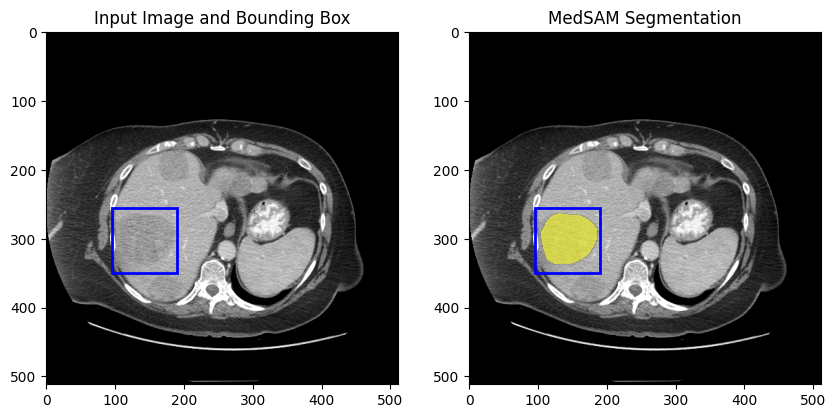

In [6]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abduzzami/cxr-all-seg")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cxr-all-seg


In [8]:
# prompt: ls /root/.cache/kagglehub/datasets/abduzzami/cxr-all-seg/versions/6

!ls /root/.cache/kagglehub/datasets/abduzzami/cxr-all-seg/versions/6

ls: cannot access '/root/.cache/kagglehub/datasets/abduzzami/cxr-all-seg/versions/6': No such file or directory


In [9]:
import os

# Path to the directory
dir_path = f'{path}/original_files'

classes = [f.name for f in os.scandir(dir_path) if f.is_dir()]

In [10]:
classes

['RC',
 'H',
 'Apical_Thickening',
 'Calcified_lymph_node',
 'Rib',
 'Calcified_Nodule',
 'Cavity',
 'RL',
 'Pleural_Effusion',
 'Miliary',
 'Severe_Infiltrate_(Consolidation)',
 'Linear_Density',
 'Small_Infiltrate_(non-linear)',
 'Thickening_of_interlobar_fissure',
 'Retraction',
 'Clustered_Nodule_(2mm-5mm_apart)',
 'Adenopathy',
 'LC',
 'LL',
 'Pleural_Thickening_(non-apical)',
 'Calcification_(other_than_nodule_lymphnod)',
 'Moderate_Infiltrate_(non-linear)',
 'Single_Nodule_(non-calcified)']

In [11]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Define the input and output directories
input_dirs = [f'{path}/prompt', f'{path}/original_files', f'{path}/masks']
output_base_dir = '/content/data'  # Directory where train and test will be saved
output_dirs = ['train', 'test']

# Calcification_(other_than_nodule_lymphnod) 0.15
# Single_Nodule_(non-calcified) 0.29
# Pleural_Thickening_(non-apical 0.05
# Thickening_of_interlobar_fissur 0.01
# Linear_Density 0.13

# selected_cats = [
#  'Apical_Thickening',
#  'Calcified_lymph_node',
#  'Calcified_Nodule',
#  'Cavity',
#  'Pleural_Effusion',
#  'Miliary',
#  'Severe_Infiltrate_(Consolidation)',
#  # 'Linear_Density',
#  'Small_Infiltrate_(non-linear)',
#  # 'Thickening_of_interlobar_fissure',
#  'Retraction',
#  'Clustered_Nodule_(2mm-5mm_apart)',
#  'Adenopathy',
#  # 'Pleural_Thickening_(non-apical)',
#  # 'Calcification_(other_than_nodule_lymphnod)',
#  'Moderate_Infiltrate_(non-linear)',
#  # 'Single_Nodule_(non-calcified)'
# ]
selected_cats = classes

# Create train and test directories
for output_dir in output_dirs:
    for input_dir in input_dirs:
        for category in os.listdir(input_dir):
            if category in selected_cats:
                category_path = os.path.join(output_base_dir, output_dir, os.path.basename(input_dir), category)
                os.makedirs(category_path, exist_ok=True)

# Split function that ensures the same files are used across directories
def split_dataset(input_dirs, output_base_dir, split_ratio=0.8):
    for category in os.listdir(input_dirs[0]):  # Assume all input dirs have the same structure
        if category in selected_cats:
            category_path = os.path.join(input_dirs[0], category)
            if os.path.isdir(category_path):
                images = os.listdir(category_path)
                random.shuffle(images)
                split_index = int(len(images) * split_ratio)
                train_images = images[:split_index]
                test_images = images[split_index:]

                for image in train_images:
                    for input_dir in input_dirs:
                        src_path = os.path.join(input_dir, category, image)
                        dest_path = os.path.join(output_base_dir, 'train', os.path.basename(input_dir), category, image)
                        shutil.copy2(src_path, dest_path)

                for image in test_images:
                    for input_dir in input_dirs:
                        src_path = os.path.join(input_dir, category, image)
                        dest_path = os.path.join(output_base_dir, 'test', os.path.basename(input_dir), category, image)
                        shutil.copy2(src_path, dest_path)

# Split each input directory set
split_dataset(input_dirs, output_base_dir, split_ratio=0.8)

print("Dataset split completed.")

Dataset split completed.


In [12]:
# prompt: /content/masks this folder has many subfolders all containing some image files. I need you to move all these files into a single folder

import os
import shutil

def copy_files_from_subfolders(source_folder, destination_folder):
    """Copies all files from subfolders within a source folder to a destination folder."""

    # Ensure the destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # Iterate through all subfolders in the source folder
    for root, _, files in os.walk(source_folder):
        for file in files:
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(destination_folder, file)

            # Copy the file
            shutil.copy(source_file_path, destination_file_path)
            # print(f"Copied: {source_file_path} to {destination_file_path}")
            # os.system('clear')


# Define source and destination folders
source_folder = '/content/data/test/original_files'
destination_folder = '/content/v2/test/original_files'

# Copy files from subfolders
copy_files_from_subfolders(source_folder, destination_folder)

source_folder = '/content/data/test//masks'
destination_folder = '/content/v2/test/masks'

# Copy files from subfolders
copy_files_from_subfolders(source_folder, destination_folder)

source_folder = '/content/data/test/prompt'
destination_folder = '/content/v2/test/prompts'

# Copy files from subfolders
copy_files_from_subfolders(source_folder, destination_folder)

###
# train

# Define source and destination folders
source_folder = '/content/data/train/original_files'
destination_folder = '/content/v2/train/original_files'

# Copy files from subfolders
copy_files_from_subfolders(source_folder, destination_folder)

source_folder = '/content/data/train//masks'
destination_folder = '/content/v2/train/masks'

# Copy files from subfolders
copy_files_from_subfolders(source_folder, destination_folder)

source_folder = '/content/data/train/prompt'
destination_folder = '/content/v2/train/prompts'

# Copy files from subfolders
copy_files_from_subfolders(source_folder, destination_folder)

In [13]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def crop_to_square_with_padding(image_path, mask_path, prompt_path, padding=10):
    # Load the chest X-ray, mask, and prompt images
    chest_xray = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    prompt = cv2.imread(prompt_path, cv2.IMREAD_UNCHANGED)

    # Ensure all have the same dimensions
    if not (chest_xray.shape[:2] == mask.shape[:2] == prompt.shape[:2]):
        raise ValueError("The chest X-ray, mask, and prompt images must have the same dimensions.")

    # Find the coordinates of the non-zero pixels in the mask
    non_zero_coords = np.argwhere(mask > 0)
    if non_zero_coords.size == 0:
        raise ValueError("The mask contains no non-zero pixels.")

    # Determine the bounding box for the non-zero pixels
    top_left = non_zero_coords.min(axis=0)
    bottom_right = non_zero_coords.max(axis=0)

    # Add padding and calculate the square bounding box
    height, width = chest_xray.shape[:2]
    box_height = bottom_right[0] - top_left[0] + 1
    box_width = bottom_right[1] - top_left[1] + 1
    max_side = max(box_height, box_width) + 2 * padding

    # Calculate the center of the bounding box
    center_x = (top_left[0] + bottom_right[0]) // 2
    center_y = (top_left[1] + bottom_right[1]) // 2

    # Calculate the new square crop coordinates
    x_min = max(center_x - max_side // 2, 0)
    x_max = min(center_x + max_side // 2, height - 1)
    y_min = max(center_y - max_side // 2, 0)
    y_max = min(center_y + max_side // 2, width - 1)

    # Adjust coordinates to ensure the crop is square
    if x_max - x_min != y_max - y_min:
        diff = abs((x_max - x_min) - (y_max - y_min))
        if x_max - x_min > y_max - y_min:
            y_max = min(y_max + diff, width - 1)
        else:
            x_max = min(x_max + diff, height - 1)

    # Check if the bounding box area with padding is greater than half the original area
    bounding_box_area = (x_max - x_min) * (y_max - y_min)
    original_area = height * width
    if bounding_box_area > original_area / 2:
        # If the bounding box area is greater than half of the original area, return the full image
        return chest_xray, mask, prompt

    # Crop the chest X-ray, mask, and prompt
    cropped_image = chest_xray[x_min:x_max+1, y_min:y_max+1]
    cropped_mask = mask[x_min:x_max+1, y_min:y_max+1]
    cropped_prompt = prompt[x_min:x_max+1, y_min:y_max+1]

    return cropped_image, cropped_mask, cropped_prompt

# Paths to folders
original_folder = '/content/v2/test/original_files'
mask_folder = '/content/v2/test/masks'
prompt_folder = '/content/v2/test/prompts'

padding = 100  # Desired padding

# Iterate through the files
for subdir, _, files in os.walk(original_folder):
    subdir_name = os.path.relpath(subdir, original_folder)
    mask_subdir = os.path.join(mask_folder, subdir_name)
    prompt_subdir = os.path.join(prompt_folder, subdir_name)

    for file in tqdm(files, desc=f"Processing {subdir_name}", unit="file"):
        original_path = os.path.join(subdir, file)
        mask_path = os.path.join(mask_subdir, file)
        prompt_path = os.path.join(prompt_subdir, file)

        if not (os.path.exists(mask_path) and os.path.exists(prompt_path)):
            continue

        try:
            cropped_image, cropped_mask, cropped_prompt = crop_to_square_with_padding(
                original_path, mask_path, prompt_path, padding=padding
            )

            # Overwrite the original files
            cv2.imwrite(original_path, cropped_image)
            cv2.imwrite(mask_path, cropped_mask)
            cv2.imwrite(prompt_path, cropped_prompt)

        except ValueError as e:
            print(f"Skipping {file}: {e}")

Processing .: 100%|██████████| 314/314 [00:22<00:00, 14.06file/s]


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def crop_to_square_with_padding(image_path, mask_path, prompt_path, padding=10):
    # Load the chest X-ray, mask, and prompt images
    chest_xray = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    prompt = cv2.imread(prompt_path, cv2.IMREAD_UNCHANGED)

    # Ensure all have the same dimensions
    if not (chest_xray.shape[:2] == mask.shape[:2] == prompt.shape[:2]):
        raise ValueError("The chest X-ray, mask, and prompt images must have the same dimensions.")

    # Find the coordinates of the non-zero pixels in the mask
    non_zero_coords = np.argwhere(mask > 0)
    if non_zero_coords.size == 0:
        raise ValueError("The mask contains no non-zero pixels.")

    # Determine the bounding box for the non-zero pixels
    top_left = non_zero_coords.min(axis=0)
    bottom_right = non_zero_coords.max(axis=0)

    # Add padding and calculate the square bounding box
    height, width = chest_xray.shape[:2]
    box_height = bottom_right[0] - top_left[0] + 1
    box_width = bottom_right[1] - top_left[1] + 1
    max_side = max(box_height, box_width) + 2 * padding

    # Calculate the center of the bounding box
    center_x = (top_left[0] + bottom_right[0]) // 2
    center_y = (top_left[1] + bottom_right[1]) // 2

    # Calculate the new square crop coordinates
    x_min = max(center_x - max_side // 2, 0)
    x_max = min(center_x + max_side // 2, height - 1)
    y_min = max(center_y - max_side // 2, 0)
    y_max = min(center_y + max_side // 2, width - 1)

    # Adjust coordinates to ensure the crop is square
    if x_max - x_min != y_max - y_min:
        diff = abs((x_max - x_min) - (y_max - y_min))
        if x_max - x_min > y_max - y_min:
            y_max = min(y_max + diff, width - 1)
        else:
            x_max = min(x_max + diff, height - 1)

    # Check if the bounding box area with padding is greater than half the original area
    bounding_box_area = (x_max - x_min) * (y_max - y_min)
    original_area = height * width
    if bounding_box_area > original_area / 2:
        # If the bounding box area is greater than half of the original area, return the full image
        return chest_xray, mask, prompt

    # Crop the chest X-ray, mask, and prompt
    cropped_image = chest_xray[x_min:x_max+1, y_min:y_max+1]
    cropped_mask = mask[x_min:x_max+1, y_min:y_max+1]
    cropped_prompt = prompt[x_min:x_max+1, y_min:y_max+1]

    return cropped_image, cropped_mask, cropped_prompt

# Paths to folders
original_folder = '/content/v2/train/original_files'
mask_folder = '/content/v2/train/masks'
prompt_folder = '/content/v2/train/prompts'

padding = 100  # Desired padding

# Iterate through the files
for subdir, _, files in os.walk(original_folder):
    subdir_name = os.path.relpath(subdir, original_folder)
    mask_subdir = os.path.join(mask_folder, subdir_name)
    prompt_subdir = os.path.join(prompt_folder, subdir_name)

    for file in tqdm(files, desc=f"Processing {subdir_name}", unit="file"):
        original_path = os.path.join(subdir, file)
        mask_path = os.path.join(mask_subdir, file)
        prompt_path = os.path.join(prompt_subdir, file)

        if not (os.path.exists(mask_path) and os.path.exists(prompt_path)):
            continue

        try:
            cropped_image, cropped_mask, cropped_prompt = crop_to_square_with_padding(
                original_path, mask_path, prompt_path, padding=padding
            )

            # Overwrite the original files
            cv2.imwrite(original_path, cropped_image)
            cv2.imwrite(mask_path, cropped_mask)
            cv2.imwrite(prompt_path, cropped_prompt)

        except ValueError as e:
            print(f"Skipping {file}: {e}")

In [14]:
# prompt: check files count inside a folder

import os

def count_files_in_folder(folder_path):
  """Counts the number of files in a folder."""
  count = 0
  for _, _, files in os.walk(folder_path):
    count += len(files)
  return count

# Example usage: count files in the 'cxrallseg' folder
folder_path = '/content/v2/test/original_files'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in {folder_path}: {file_count}")


folder_path = '/content/v2/test/masks'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in {folder_path}: {file_count}")


folder_path = '/content/v2/test/prompts'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in {folder_path}: {file_count}")

# train
# Example usage: count files in the 'cxrallseg' folder
folder_path = '/content/v2/train/original_files'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in {folder_path}: {file_count}")


folder_path = '/content/v2/train/masks'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in {folder_path}: {file_count}")


folder_path = '/content/v2/train/prompts'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in {folder_path}: {file_count}")

Number of files in /content/v2/test/original_files: 314
Number of files in /content/v2/test/masks: 314
Number of files in /content/v2/test/prompts: 314


In [15]:
# # prompt: resize all the files inside a folder into 256 256
# import cv2

# def resize_images_in_folder(folder_path, new_size=(256, 256)):
#   """Resizes all images in a folder to a specified size."""
#   for root, _, files in os.walk(folder_path):
#     for file in files:
#       if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#         image_path = os.path.join(root, file)
#         try:
#           img = cv2.imread(image_path)
#           if img is not None:
#             resized_img = cv2.resize(img, new_size)
#             cv2.imwrite(image_path, resized_img)
#             # print(f"Resized: {image_path}")
#         except Exception as e:
#           print(f"Error processing {image_path}: {e}")

# # Example usage:
# folder_path = '/content/v2/test/original_files'  # Replace with your folder path
# resize_images_in_folder(folder_path)

# folder_path = '/content/v2/test/masks'  # Replace with your folder path
# resize_images_in_folder(folder_path)

# folder_path = '/content/v2/test/prompts'  # Replace with your folder path
# resize_images_in_folder(folder_path)

In [16]:
# # prompt: convert all the images of a folder into grayscale

# def convert_to_grayscale(folder_path):
#   """Converts all images in a folder to grayscale."""
#   for root, _, files in os.walk(folder_path):
#     for file in files:
#       if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#         image_path = os.path.join(root, file)
#         try:
#           img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
#           if img is not None:
#             cv2.imwrite(image_path, img)
#             # print(f"Converted to grayscale: {image_path}")
#         except Exception as e:
#           print(f"Error processing {image_path}: {e}")

# # Example usage:
# folder_path = '/content/v2/test/original_files'  # Replace with your folder path
# convert_to_grayscale(folder_path)

# folder_path = '/content/v2/test/masks'  # Replace with your folder path
# convert_to_grayscale(folder_path)

# folder_path = '/content/v2/test/prompts'  # Replace with your folder path
# convert_to_grayscale(folder_path)

In [17]:
# import os
# import cv2
# from tqdm import tqdm

# def apply_histogram_equalization(folder_path):
#     """
#     Apply histogram equalization to all images in the given folder and its subdirectories.

#     Args:
#         folder_path (str): Path to the root folder containing images.
#     """
#     # Walk through all directories and subdirectories
#     for subdir, _, files in os.walk(folder_path):
#         for filename in tqdm(files, desc=f"Processing {subdir}"):
#             # Construct full file path
#             file_path = os.path.join(subdir, filename)

#             # Check if it's a valid image file
#             if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
#                 # Read the image
#                 image = cv2.imread(file_path)

#                 if image is None:
#                     print(f"Skipping {filename}, unable to read.")
#                     continue

#                 # Convert to grayscale if needed
#                 if len(image.shape) == 3:
#                     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#                 # Apply Histogram Equalization
#                 equalized_image = cv2.equalizeHist(image)

#                 # Save the equalized image at the same location, overwriting the original
#                 cv2.imwrite(file_path, equalized_image)

# #                 print(f"Equalized {file_path},")

#     print("Histogram Equalization processing completed.")

# # Example usage
# apply_histogram_equalization("/content/v2/test/original_files")

In [18]:
# prompt: segmentatio mask predict by medsam for this image /content/v2/test/original_files/CHNCXR_0328_1_Small_Infiltrate_(non-linear)_2.png take bbox from is /content/v2/test/masks/CHNCXR_0328_1_Small_Infiltrate_(non-linear)_2.png to find the bbox consider a box around the mask add a small padding also

import matplotlib.pyplot as plt
import numpy as np
# Function to find bounding box around a mask
def get_bbox_from_mask(mask_path, padding=10):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask file not found at {mask_path}")

    # Find the coordinates of the non-zero pixels in the mask
    non_zero_coords = np.argwhere(mask > 0)
    if non_zero_coords.size == 0:
        raise ValueError(f"The mask file {mask_path} contains no non-zero pixels.")

    # Determine the bounding box for the non-zero pixels
    top_left = non_zero_coords.min(axis=0)
    bottom_right = non_zero_coords.max(axis=0)

    # Extract bounding box coordinates
    y_min, x_min = top_left
    y_max, x_max = bottom_right

    # Add padding
    img_h, img_w = mask.shape
    x_min_padded = max(0, x_min - padding)
    y_min_padded = max(0, y_min - padding)
    x_max_padded = min(img_w - 1, x_max + padding)
    y_max_padded = min(img_h - 1, y_max + padding)

    # Return the bounding box in x_min, y_min, x_max, y_max format
    return np.array([[x_min_padded, y_min_padded, x_max_padded, y_max_padded]])

# # Define the paths
# image_path = '/content/v2/test/original_files/CHNCXR_0328_1_Small_Infiltrate_(non-linear)_2.png'
# mask_path = '/content/v2/test/masks/CHNCXR_0328_1_Small_Infiltrate_(non-linear)_2.png'

# # Load the image
# img_np = io.imread(image_path)
# if len(img_np.shape) == 2:
#     img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
# else:
#     img_3c = img_np
# H, W, _ = img_3c.shape

# # Get the bounding box from the mask with padding
# try:
#     box_np = get_bbox_from_mask(mask_path, padding=20) # Add some padding
# except (FileNotFoundError, ValueError) as e:
#     print(f"Error getting bounding box: {e}")
#     # Handle the error, e.g., skip this image or use a default bbox
#     box_np = None # Or a default box like np.array([[0, 0, W-1, H-1]])

# if box_np is not None:
#     # Preprocess the image for MedSAM
#     img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
#     img_1024 = (img_1024 - img_1024.min()) / np.clip(
#         img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
#     )
#     img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

#     # Transfer bounding box to 1024x1024 scale
#     box_1024 = box_np / np.array([W, H, W, H]) * 1024

#     # Get image embedding
#     with torch.no_grad():
#         image_embedding = medsam_model.image_encoder(img_1024_tensor)

#     # Perform inference
#     medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

#     # Visualize results
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].imshow(img_3c)
#     show_box(box_np[0], ax[0])
#     ax[0].set_title("Input Image and Bounding Box")
#     ax[1].imshow(img_3c)
#     show_mask(medsam_seg, ax[1])
#     show_box(box_np[0], ax[1]) # Optionally show the bbox on the segmented image
#     ax[1].set_title("MedSAM Segmentation")
#     plt.show()
# else:
#     print(f"Could not generate segmentation for {image_path} due to issues with the mask.")



In [19]:
# prompt: calculate dice and jaccard and accuracy and auc

import numpy as np
from sklearn.metrics import accuracy_score, jaccard_score, roc_auc_score, confusion_matrix

def calculate_metrics(ground_truth_folder, segmentation_folder):
    """
    Calculates Dice, Jaccard, Accuracy, and AUC scores for segmentation masks
    compared to ground truth masks across all files in specified folders.

    Args:
        ground_truth_folder (str): Path to the folder containing ground truth masks.
        segmentation_folder (str): Path to the folder containing segmentation masks.

    Returns:
        dict: A dictionary containing the average Dice, Jaccard, Accuracy,
              and AUC scores, and the number of processed images.
    """
    dice_scores = []
    jaccard_scores = []
    accuracy_scores = []
    auc_scores = []
    num_processed_images = 0

    # Walk through all directories and subdirectories in the ground truth folder
    for subdir, _, files in os.walk(ground_truth_folder):
        # Get the corresponding subdirectory in the segmentation folder
        segmentation_subdir = os.path.join(segmentation_folder, os.path.relpath(subdir, ground_truth_folder))

        for filename in tqdm(files, desc=f"Calculating metrics for {subdir}"):
            ground_truth_path = os.path.join(subdir, filename)
            segmentation_path = os.path.join(segmentation_subdir, filename)

            # Check if both ground truth and segmentation files exist
            if os.path.exists(segmentation_path):
                try:
                    # Load the ground truth and segmentation masks
                    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
                    segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

                    if ground_truth is None or segmentation is None:
                        print(f"Skipping {filename}, unable to read images.")
                        continue

                    # Ensure both masks have the same dimensions
                    if ground_truth.shape != segmentation.shape:
                        print(f"Skipping {filename}, dimension mismatch.")
                        continue

                    # Flatten the masks
                    ground_truth_flat = ground_truth.flatten() > 0.5
                    segmentation_flat = segmentation.flatten() > 0.5

                    # Calculate Dice score
                    intersection = np.sum(ground_truth_flat * segmentation_flat)
                    sum_of_masks = np.sum(ground_truth_flat) + np.sum(segmentation_flat)
                    dice = (2. * intersection) / (sum_of_masks + 1e-8) # Add epsilon for numerical stability
                    dice_scores.append(dice)

                    # Calculate Jaccard score (IoU)
                    union = np.sum((ground_truth_flat | segmentation_flat))
                    jaccard = intersection / (union + 1e-8) # Add epsilon for numerical stability
                    jaccard_scores.append(jaccard)

                    # Calculate Accuracy
                    accuracy = accuracy_score(ground_truth_flat, segmentation_flat)
                    accuracy_scores.append(accuracy)

                    # Calculate AUC
                    # Ensure there are both positive and negative classes for AUC
                    if len(np.unique(ground_truth_flat)) == 2:
                         # Use the segmentation values as probabilities for AUC
                         auc = roc_auc_score(ground_truth_flat, segmentation.flatten() / 255.0) # Normalize to [0, 1]
                         auc_scores.append(auc)
                    else:
                         # print(f"Skipping AUC for {filename}, only one class present in ground truth.")
                         pass # Skip AUC calculation if only one class is present

                    num_processed_images += 1

                except Exception as e:
                    print(f"Error processing {filename}: {e}")

    # Calculate average scores
    avg_dice = np.mean(dice_scores) if dice_scores else 0
    avg_jaccard = np.mean(jaccard_scores) if jaccard_scores else 0
    avg_accuracy = np.mean(accuracy_scores) if accuracy_scores else 0
    avg_auc = np.mean(auc_scores) if auc_scores else 0

    return {
        'avg_dice': avg_dice,
        'avg_jaccard': avg_jaccard,
        'avg_accuracy': avg_accuracy,
        'avg_auc': avg_auc,
        'num_processed_images': num_processed_images
    }

# Define the folders containing the ground truth and segmentation masks
ground_truth_folder = '/content/v2/test/masks' # Replace with your ground truth masks folder
segmentation_folder = '/content/v2/test/medsam_segmentations' # Replace with your MedSAM segmentations folder

# Ensure the segmentation output folder exists
os.makedirs(segmentation_folder, exist_ok=True)

# Function to perform MedSAM inference on a single image and save the result
def process_single_image(image_path, mask_path, output_segmentation_path, medsam_model, device, padding=20):
    """
    Performs MedSAM inference on a single image using a bounding box derived
    from the corresponding ground truth mask and saves the resulting segmentation.

    Args:
        image_path (str): Path to the input image.
        mask_path (str): Path to the ground truth mask (used to generate bbox).
        output_segmentation_path (str): Path to save the resulting segmentation mask.
        medsam_model: The loaded MedSAM model.
        device (str): The device to run inference on ('cuda:0' or 'cpu').
        padding (int): Padding around the bounding box.
    """
    try:
        # Load the image
        img_np = io.imread(image_path)
        if len(img_np.shape) == 2:
            img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
        else:
            img_3c = img_np
        H, W, _ = img_3c.shape

        # Get the bounding box from the mask with padding
        box_np = get_bbox_from_mask(mask_path, padding=padding)

        # Preprocess the image for MedSAM
        img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
        img_1024 = (img_1024 - img_1024.min()) / np.clip(
            img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
        )
        img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

        # Transfer bounding box to 1024x1024 scale
        box_1024 = box_np / np.array([W, H, W, H]) * 1024

        # Get image embedding
        with torch.no_grad():
            image_embedding = medsam_model.image_encoder(img_1024_tensor)

        # Perform inference
        medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

        # Save the segmentation mask (as grayscale image)
        cv2.imwrite(output_segmentation_path, medsam_seg * 255) # Save as 0 or 255

    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping {os.path.basename(image_path)}: {e}")
    except Exception as e:
        print(f"Error processing {os.path.basename(image_path)}: {e}")

# Iterate through the ground truth masks and perform inference
original_files_folder = '/content/v2/test/original_files'
mask_files_folder = '/content/v2/test/masks'

for subdir, _, files in os.walk(original_files_folder):
    # Get the corresponding subdirectory in the masks and output segmentation folders
    mask_subdir = os.path.join(mask_files_folder, os.path.relpath(subdir, original_files_folder))
    segmentation_subdir = os.path.join(segmentation_folder, os.path.relpath(subdir, original_files_folder))

    # Create the output segmentation subdirectory if it doesn't exist
    os.makedirs(segmentation_subdir, exist_ok=True)

    for filename in tqdm(files, desc=f"Performing inference for {subdir}"):
        image_path = os.path.join(subdir, filename)
        mask_path = os.path.join(mask_subdir, filename)
        output_segmentation_path = os.path.join(segmentation_subdir, filename)

        # Ensure the corresponding mask file exists
        if os.path.exists(mask_path):
            process_single_image(image_path, mask_path, output_segmentation_path, medsam_model, device)
        # else:
            # print(f"Skipping inference for {filename}, mask not found.")


print("MedSAM inference completed.")

# Calculate and print the metrics
metrics = calculate_metrics(ground_truth_folder, segmentation_folder)

print("\n--- Evaluation Metrics ---")
print(f"Number of images processed: {metrics['num_processed_images']}")
print(f"Average Dice Score: {metrics['avg_dice']:.4f}")
print(f"Average Jaccard Score: {metrics['avg_jaccard']:.4f}")
print(f"Average Accuracy: {metrics['avg_accuracy']:.4f}")
print(f"Average AUC Score: {metrics['avg_auc']:.4f}")
print("-------------------------")

Performing inference for /content/v2/test/original_files: 100%|██████████| 314/314 [12:29<00:00,  2.39s/it]


MedSAM inference completed.


Calculating metrics for /content/v2/test/masks: 100%|██████████| 314/314 [00:19<00:00, 15.83it/s]


--- Evaluation Metrics ---
Number of images processed: 314
Average Dice Score: 0.6633
Average Jaccard Score: 0.5434
Average Accuracy: 0.9342
Average AUC Score: 0.9285
-------------------------


In [20]:
import os

import os

def extract_class_from_filename(filename):
    name, _ = os.path.splitext(filename)
    parts = name.split('_')

    if name.startswith('CHNCXR'):
        if len(parts) > 4:
            return '_'.join(parts[3:-1])
        else:
            return "Unknown"

    elif name.startswith('JPC'):
        if len(parts) >= 2:
            return parts[-1]
        else:
            return "Unknown"

    elif name.startswith('vindir'):
        if len(parts) >= 2:
            return parts[1]
        else:
            return "Unknown"

    return "Unknown"


# Test cases
print(extract_class_from_filename('CHNCXR_0328_1_Small_Infiltrate_(non-linear)_2.png'))  # ➝ Small_Infiltrate_(non-linear)
print(extract_class_from_filename('JPCLN001_RL.png'))                                     # ➝ RL


Small_Infiltrate_(non-linear)
RL


In [21]:
import os

import os

def extract_class_from_filename(filename):
    name, _ = os.path.splitext(filename)
    parts = name.split('_')

    if name.startswith('CHNCXR'):
        if len(parts) > 4:
            return '_'.join(parts[3:-1])
        else:
            return "Unknown"

    elif name.startswith('JPC'):
        if len(parts) >= 2:
            return parts[-1]
        else:
            return "Unknown"

    elif name.startswith('vindir'):
        if len(parts) >= 2:
            return parts[1]
        else:
            return "Unknown"

    return "Unknown"


def check_folder_for_unknowns(folder_path):
    unknown_files = []

    for fname in os.listdir(folder_path):
        if fname.lower().endswith('.png'):
            label = extract_class_from_filename(fname)
            if label == "Unknown":
                unknown_files.append(fname)

    print(f"Total Unknowns: {len(unknown_files)}")
    for f in unknown_files:
        print(f"Unknown class -> {f}")

# Example usage — replace this with your folder path
check_folder_for_unknowns("/content/v2/test/masks")


Total Unknowns: 0


In [22]:
# prompt: can you find dice jaccarda auc accuracy class wise? if the filename is /content/v2/test/original_files/CHNCXR_0328_1_Small_Infiltrate_(non-linear)_2.png class is 'Small_Infiltrate_(non-linear)' there are more classes like this. take classname from filename like this

import numpy as np
import os

def extract_class_from_filename(filename):
    name, _ = os.path.splitext(filename)
    parts = name.split('_')

    if name.startswith('CHNCXR'):
        if len(parts) > 4:
            return '_'.join(parts[3:-1])
        else:
            return "Unknown"

    elif name.startswith('JPC'):
        if len(parts) >= 2:
            return parts[-1]
        else:
            return "Unknown"

    elif name.startswith('vindir'):
        if len(parts) >= 2:
            return parts[1]
        else:
            return "Unknown"

    return "Unknown"


def calculate_classwise_metrics(ground_truth_folder, segmentation_folder):
    """
    Calculates Dice, Jaccard, Accuracy, and AUC scores class-wise for segmentation masks
    compared to ground truth masks across all files in specified folders.

    Args:
        ground_truth_folder (str): Path to the folder containing ground truth masks.
        segmentation_folder (str): Path to the folder containing segmentation masks.

    Returns:
        dict: A dictionary where keys are class names and values are dictionaries
              containing average Dice, Jaccard, Accuracy, and AUC scores for that class,
              and the number of processed images for that class.
    """
    class_metrics = {}

    # Walk through all directories and subdirectories in the ground truth folder
    for subdir, _, files in os.walk(ground_truth_folder):
        # Get the corresponding subdirectory in the segmentation folder
        segmentation_subdir = os.path.join(segmentation_folder, os.path.relpath(subdir, ground_truth_folder))

        for filename in tqdm(files, desc=f"Calculating metrics for {subdir}"):
            ground_truth_path = os.path.join(subdir, filename)
            segmentation_path = os.path.join(segmentation_subdir, filename)

            # Extract class name from the filename
            class_name = extract_class_from_filename(filename)

            # Initialize metrics for the class if not present
            if class_name not in class_metrics:
                class_metrics[class_name] = {
                    'dice_scores': [],
                    'jaccard_scores': [],
                    'accuracy_scores': [],
                    'auc_scores': [],
                    'num_processed_images': 0
                }

            # Check if both ground truth and segmentation files exist
            if os.path.exists(segmentation_path):
                try:
                    # Load the ground truth and segmentation masks
                    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
                    segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

                    if ground_truth is None or segmentation is None:
                        print(f"Skipping {filename}, unable to read images.")
                        continue

                    # Ensure both masks have the same dimensions
                    if ground_truth.shape != segmentation.shape:
                        print(f"Skipping {filename}, dimension mismatch.")
                        continue

                    # Flatten the masks
                    ground_truth_flat = ground_truth.flatten() > 0.5
                    segmentation_flat = segmentation.flatten() > 0.5

                    # Calculate Dice score
                    intersection = np.sum(ground_truth_flat * segmentation_flat)
                    sum_of_masks = np.sum(ground_truth_flat) + np.sum(segmentation_flat)
                    dice = (2. * intersection) / (sum_of_masks + 1e-8) # Add epsilon for numerical stability
                    class_metrics[class_name]['dice_scores'].append(dice)

                    # Calculate Jaccard score (IoU)
                    union = np.sum((ground_truth_flat | segmentation_flat))
                    jaccard = intersection / (union + 1e-8) # Add epsilon for numerical stability
                    class_metrics[class_name]['jaccard_scores'].append(jaccard)

                    # Calculate Accuracy
                    accuracy = accuracy_score(ground_truth_flat, segmentation_flat)
                    class_metrics[class_name]['accuracy_scores'].append(accuracy)

                    # Calculate AUC
                    # Ensure there are both positive and negative classes for AUC
                    if len(np.unique(ground_truth_flat)) == 2:
                         # Use the segmentation values as probabilities for AUC
                         auc = roc_auc_score(ground_truth_flat, segmentation.flatten() / 255.0) # Normalize to [0, 1]
                         class_metrics[class_name]['auc_scores'].append(auc)
                    else:
                         # print(f"Skipping AUC for {filename}, only one class present in ground truth.")
                         pass # Skip AUC calculation if only one class is present


                    class_metrics[class_name]['num_processed_images'] += 1

                except Exception as e:
                    print(f"Error processing {filename}: {e}")

    # Calculate average scores for each class
    for class_name, metrics_data in class_metrics.items():
        metrics_data['avg_dice'] = np.mean(metrics_data['dice_scores']) if metrics_data['dice_scores'] else 0
        metrics_data['avg_jaccard'] = np.mean(metrics_data['jaccard_scores']) if metrics_data['jaccard_scores'] else 0
        metrics_data['avg_accuracy'] = np.mean(metrics_data['accuracy_scores']) if metrics_data['accuracy_scores'] else 0
        metrics_data['avg_auc'] = np.mean(metrics_data['auc_scores']) if metrics_data['auc_scores'] else 0

        # Remove the lists of individual scores to keep the output clean
        del metrics_data['dice_scores']
        del metrics_data['jaccard_scores']
        del metrics_data['accuracy_scores']
        del metrics_data['auc_scores']

    return class_metrics

# Define the folders containing the ground truth and segmentation masks
ground_truth_folder = '/content/v2/test/masks' # Replace with your ground truth masks folder
segmentation_folder = '/content/v2/test/medsam_segmentations' # Replace with your MedSAM segmentations folder

# Calculate and print the class-wise metrics
classwise_metrics = calculate_classwise_metrics(ground_truth_folder, segmentation_folder)

print("\n--- Class-wise Evaluation Metrics ---")
for class_name, metrics in classwise_metrics.items():
    print(f"\nClass: {class_name} ({metrics['num_processed_images']} images)")
    print(f"  Average Dice Score: {metrics['avg_dice']:.4f}")
    print(f"  Average Jaccard Score: {metrics['avg_jaccard']:.4f}")
    print(f"  Average Accuracy: {metrics['avg_accuracy']:.4f}")
    print(f"  Average AUC Score: {metrics['avg_auc']:.4f}")

print("\n-------------------------")


Calculating metrics for /content/v2/test/masks: 100%|██████████| 314/314 [00:20<00:00, 15.20it/s]


--- Class-wise Evaluation Metrics ---

Class: Adenopathy (10 images)
  Average Dice Score: 0.7239
  Average Jaccard Score: 0.5720
  Average Accuracy: 0.9523
  Average AUC Score: 0.9240

Class: Rib (20 images)
  Average Dice Score: 0.5149
  Average Jaccard Score: 0.3482
  Average Accuracy: 0.6177
  Average AUC Score: 0.7020

Class: Linear_Density (10 images)
  Average Dice Score: 0.4250
  Average Jaccard Score: 0.2894
  Average Accuracy: 0.9667
  Average AUC Score: 0.9593

Class: Pleural_Effusion (10 images)
  Average Dice Score: 0.5581
  Average Jaccard Score: 0.4027
  Average Accuracy: 0.9172
  Average AUC Score: 0.8482

Class: Pleural_Thickening_(non-apical) (10 images)
  Average Dice Score: 0.3862
  Average Jaccard Score: 0.2428
  Average Accuracy: 0.9569
  Average AUC Score: 0.9638

Class: Moderate_Infiltrate_(non-linear) (10 images)
  Average Dice Score: 0.7182
  Average Jaccard Score: 0.5686
  Average Accuracy: 0.9439
  Average AUC Score: 0.9206

Class: RL (30 images)
  Average 

In [ ]:
# prompt: how can i train the medsam or fine tune medsam with my dataset

# Training MedSAM or fine-tuning requires a training loop.
# Here's a general structure for fine-tuning MedSAM on a custom dataset.
# This is a conceptual example and would need significant
# adaptation based on your specific dataset and training requirements.

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import random
import numpy as np
import cv2

# Define your custom dataset class
class CustomMedSAMDataset(Dataset):
    def __init__(self, original_dir, mask_dir, prompt_dir, transform=None):
        """
        Args:
            original_dir (str): Directory with original images.
            mask_dir (str): Directory with mask images.
            prompt_dir (str): Directory with prompt images (e.g., bounding boxes).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.original_dir = original_dir
        self.mask_dir = mask_dir
        self.prompt_dir = prompt_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, f))]
        # Assuming mask and prompt files have the same names as original files
        self.mask_files = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]
        self.prompt_files = [f for f in os.listdir(prompt_dir) if os.path.isfile(os.path.join(prompt_dir, f))]

        # Ensure consistency between files
        common_files = list(set(self.image_files) & set(self.mask_files) & set(self.prompt_files))
        self.image_files = common_files
        self.mask_files = common_files
        self.prompt_files = common_files

        print(f"Found {len(self.image_files)} image files in the dataset.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = self.mask_files[idx]
        prompt_name = self.prompt_files[idx]

        img_path = os.path.join(self.original_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        prompt_path = os.path.join(self.prompt_dir, prompt_name)

        # Load images and masks
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Assuming grayscale input
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 0 # Assuming grayscale mask, convert to binary
        prompt_img = cv2.imread(prompt_path, cv2.IMREAD_GRAYSCALE) # Assuming grayscale prompt (if needed for visual prompts)

        if image is None or mask is None or prompt_img is None:
            print(f"Warning: Could not load one or more files for index {idx}: {img_path}, {mask_path}, {prompt_path}")
            # Return None or raise an error, or handle in the DataLoader collate_fn
            return None

        # Convert to RGB for MedSAM image encoder (which expects 3 channels)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Get bounding box from the mask
        non_zero_coords = np.argwhere(mask)
        if non_zero_coords.size == 0:
             # Handle cases with empty masks - perhaps return None or a default box
             print(f"Warning: Empty mask for file: {mask_path}")
             # You might want to skip this sample in the DataLoader's collate_fn
             return None

        y_min, x_min = non_zero_coords.min(axis=0)
        y_max, x_max = non_zero_coords.max(axis=0)
        # Bbox format: x_min, y_min, x_max, y_max
        bbox = np.array([x_min, y_min, x_max, y_max])

        # Convert to torch tensors
        image_tensor = torch.tensor(image_rgb).float().permute(2, 0, 1) # (3, H, W)
        mask_tensor = torch.tensor(mask).long() # (H, W), Long type for loss
        bbox_tensor = torch.tensor(bbox).float() # (4,)

        sample = {'image': image_tensor, 'mask': mask_tensor, 'bbox': bbox_tensor}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Define transformations
class ResizeAndPad(object):
    """Resize image, mask, and bbox to a target size and pad to a square."""
    def __init__(self, target_size=1024):
        self.target_size = target_size

    def __call__(self, sample):
        image, mask, bbox = sample['image'], sample['mask'], sample['bbox']
        original_h, original_w = image.shape[-2:]

        # Resize image, mask
        image = F.interpolate(image.unsqueeze(0), size=(self.target_size, self.target_size), mode='bilinear', align_corners=False).squeeze(0)
        # Use nearest for mask to keep integer values
        mask = F.interpolate(mask.float().unsqueeze(0).unsqueeze(0), size=(self.target_size, self.target_size), mode='nearest').squeeze(0).squeeze(0).long()

        # Resize bounding box coordinates
        scale_x = self.target_size / original_w
        scale_y = self.target_size / original_h
        resized_bbox = torch.tensor([
            bbox[0] * scale_x,
            bbox[1] * scale_y,
            bbox[2] * scale_x,
            bbox[3] * scale_y
        ]).float()

        return {'image': image, 'mask': mask, 'bbox': resized_bbox}


# Collate function to handle None samples from dataset
def collate_fn(batch):
    batch = [item for item in batch if item is not None] # Filter out None samples
    if not batch:
        return None # Return None if the batch is empty after filtering
    return torch.utils.data.dataloader.default_collate(batch)


# --- Training Configuration ---
train_original_dir = '/content/v2/train/original_files' # Update with your train paths
train_mask_dir = '/content/v2/train/masks'
train_prompt_dir = '/content/v2/train/prompts' # Or create prompts if not available

test_original_dir = '/content/v2/test/original_files' # Update with your validation/test paths
test_mask_dir = '/content/v2/test/masks'
test_prompt_dir = '/content/v2/test/prompts'

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the pre-trained MedSAM model
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth" # Ensure this path is correct
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(DEVICE)
medsam_model.train() # Set model to training mode

# --- Freezing Layers (Optional but Recommended for Fine-tuning) ---
# You might want to freeze the image encoder and only train the prompt encoder and mask decoder
# or train the entire model with a lower learning rate.

# Example: Freeze the image encoder
for param in medsam_model.image_encoder.parameters():
    param.requires_grad = False

# Ensure prompt encoder and mask decoder are trainable
for param in medsam_model.prompt_encoder.parameters():
    param.requires_grad = True
for param in medsam_model.mask_decoder.parameters():
    param.requires_grad = True
# -----------------------------------------------------------------


# Define dataset and dataloader
train_dataset = CustomMedSAMDataset(
    train_original_dir,
    train_mask_dir,
    train_prompt_dir,
    transform=ResizeAndPad(target_size=1024) # Resize images and masks to 1024x1024
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2, # Adjust based on your system
    collate_fn=collate_fn
)

# Define Optimizer and Loss Function
optimizer = optim.AdamW(medsam_model.parameters(), lr=LEARNING_RATE)
# MedSAM typically uses a combination of Focal Loss and Dice Loss
# You might need to implement or import these loss functions
# For simplicity, let's use a basic BCELoss with logits for demonstration
loss_fn = torch.nn.BCEWithLogitsLoss() # Binary Cross-Entropy with Logits

# --- Training Loop ---
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    processed_batches = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        if batch is None:
            # Skip empty batches
            continue

        images = batch['image'].to(DEVICE) # (B, 3, 1024, 1024)
        masks = batch['mask'].to(DEVICE)   # (B, 1024, 1024)
        bboxes = batch['bbox'].to(DEVICE) # (B, 4)

        optimizer.zero_grad()

        # --- Forward Pass ---
        # 1. Get image embeddings
        with torch.no_grad(): # Keep image encoder frozen if applicable
             image_embeddings = medsam_model.image_encoder(images) # (B, 256, 64, 64)

        # 2. Get prompt embeddings (using bounding box)
        sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
            points=None,
            boxes=bboxes[:, None, :], # Reshape bbox for prompt encoder (B, 1, 4)
            masks=None,
        )

        # 3. Get mask predictions from the decoder
        low_res_logits, _ = medsam_model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64) - assumed fixed
            sparse_prompt_embeddings=sparse_embeddings, # (B, 1, 256) or (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        ) # (B, 1, 256, 256)

        # Resize predicted logits to original mask size for loss calculation
        # Ensure masks are the same size as the predicted low_res_logits for loss
        # If your mask target size is 1024, and output logits are 256, resize the logits
        # Or, resize the masks to 256 for loss calculation. MedSAM typically outputs
        # 256x256 logits which are then upscaled to the original image size for inference.
        # For training, you can compare 256x256 logits with resized masks.

        # Resize target masks to match the output logits size (256x256)
        # This is a common practice in SAM/MedSAM training
        masks_resized = F.interpolate(
            masks.float().unsqueeze(1), # (B, 1, H, W)
            size=low_res_logits.shape[-2:], # (256, 256)
            mode="nearest",
        ).squeeze(1).long() # (B, 256, 256)


        # Calculate Loss
        # Need to reshape logits and masks to (B*H*W) for loss
        loss = loss_fn(low_res_logits.squeeze(1), masks_resized.float()) # Squeeze channel dim

        # --- Backward Pass and Optimization ---
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        processed_batches += 1

    avg_epoch_loss = epoch_loss / processed_batches if processed_batches > 0 else 0
    print(f"Epoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f}")

    # --- (Optional) Validation/Evaluation after each epoch ---
    # You can add a validation loop here using the test dataset
    # and calculate metrics like Dice, IoU.
    # Remember to set the model to eval() mode during validation and use torch.no_grad()

print("Training finished.")

# --- Save the fine-tuned model ---
torch.save(medsam_model.state_dict(), '/content/medsam_finetuned.pth')
print("Fine-tuned model saved to /content/medsam_finetuned.pth")



Found 314 image files in the dataset.
Starting training...


Epoch 1/10: 100%|██████████| 79/79 [02:24<00:00,  1.82s/it]


Epoch 1 finished. Average Loss: 0.0982


Epoch 2/10: 100%|██████████| 79/79 [02:24<00:00,  1.83s/it]


Epoch 2 finished. Average Loss: 0.0809


Epoch 3/10: 100%|██████████| 79/79 [02:24<00:00,  1.82s/it]


Epoch 3 finished. Average Loss: 0.0771


Epoch 4/10: 100%|██████████| 79/79 [02:24<00:00,  1.83s/it]


Epoch 4 finished. Average Loss: 0.0701


Epoch 5/10:  61%|██████    | 48/79 [01:29<00:57,  1.84s/it]

In [24]:
# --- Evaluation with the fine-tuned model ---
# You would load the fine-tuned model and run the inference and evaluation steps
# you already have, but using the new model checkpoint.

fine_tuned_model_path = '/content/medsam_finetuned.pth'

# Load the fine-tuned model
# Pass the checkpoint path to the model registry function
fine_tuned_medsam_model = sam_model_registry['vit_b'](checkpoint=fine_tuned_model_path)
fine_tuned_medsam_model = fine_tuned_medsam_model.to(DEVICE)
fine_tuned_medsam_model.eval() # Set to evaluation mode

# Define output directory for fine-tuned model segmentations
finetuned_segmentation_folder = '/content/v2/test/finetuned_medsam_segmentations'
os.makedirs(finetuned_segmentation_folder, exist_ok=True)

print("\nStarting evaluation with fine-tuned model...")
# Iterate through the test set and perform inference with the fine-tuned model
for subdir, _, files in os.walk(test_original_dir):
    mask_subdir = os.path.join(test_mask_dir, os.path.relpath(subdir, test_original_dir))
    segmentation_subdir = os.path.join(finetuned_segmentation_folder, os.path.relpath(subdir, test_original_dir))
    os.makedirs(segmentation_subdir, exist_ok=True)

    for filename in tqdm(files, desc=f"Inference with fine-tuned model for {subdir}"):
        image_path = os.path.join(subdir, filename)
        mask_path = os.path.join(mask_subdir, filename) # Still use the original mask to get the bbox for evaluation
        output_segmentation_path = os.path.join(segmentation_subdir, filename)

        if os.path.exists(mask_path):
             # Use the fine-tuned model for inference
             process_single_image(image_path, mask_path, output_segmentation_path, fine_tuned_medsam_model, DEVICE)


print("Fine-tuned MedSAM inference completed.")

# Calculate and print the metrics for the fine-tuned model
finetuned_metrics = calculate_metrics(test_mask_dir, finetuned_segmentation_folder)

print("\n--- Fine-tuned Model Evaluation Metrics ---")
print(f"Number of images processed: {finetuned_metrics['num_processed_images']}")
print(f"Average Dice Score: {finetuned_metrics['avg_dice']:.4f}")
print(f"Average Jaccard Score: {finetuned_metrics['avg_jaccard']:.4f}")
print(f"Average Accuracy: {finetuned_metrics['avg_accuracy']:.4f}")
print(f"Average AUC Score: {finetuned_metrics['avg_auc']:.4f}")
print("----------------------------------------")


Starting evaluation with fine-tuned model...


Inference with fine-tuned model for /content/v2/test/original_files: 100%|██████████| 314/314 [12:24<00:00,  2.37s/it]


Fine-tuned MedSAM inference completed.


Calculating metrics for /content/v2/test/masks: 100%|██████████| 314/314 [00:18<00:00, 16.65it/s]


--- Fine-tuned Model Evaluation Metrics ---
Number of images processed: 314
Average Dice Score: 0.6785
Average Jaccard Score: 0.5569
Average Accuracy: 0.9456
Average AUC Score: 0.9309
----------------------------------------


In [25]:
# prompt: can you find dice jaccarda auc accuracy class wise? if the filename is /content/v2/test/original_files/CHNCXR_0328_1_Small_Infiltrate_(non-linear)_2.png class is 'Small_Infiltrate_(non-linear)' there are more classes like this. take classname from filename like this

import numpy as np
import os

def extract_class_from_filename(filename):
    name, _ = os.path.splitext(filename)
    parts = name.split('_')

    if name.startswith('CHNCXR'):
        if len(parts) > 4:
            return '_'.join(parts[3:-1])
        else:
            return "Unknown"

    elif name.startswith('JPC'):
        if len(parts) >= 2:
            return parts[-1]
        else:
            return "Unknown"

    elif name.startswith('vindir'):
        if len(parts) >= 2:
            return parts[1]
        else:
            return "Unknown"

    return "Unknown"


def calculate_classwise_metrics(ground_truth_folder, segmentation_folder):
    """
    Calculates Dice, Jaccard, Accuracy, and AUC scores class-wise for segmentation masks
    compared to ground truth masks across all files in specified folders.

    Args:
        ground_truth_folder (str): Path to the folder containing ground truth masks.
        segmentation_folder (str): Path to the folder containing segmentation masks.

    Returns:
        dict: A dictionary where keys are class names and values are dictionaries
              containing average Dice, Jaccard, Accuracy, and AUC scores for that class,
              and the number of processed images for that class.
    """
    class_metrics = {}

    # Walk through all directories and subdirectories in the ground truth folder
    for subdir, _, files in os.walk(ground_truth_folder):
        # Get the corresponding subdirectory in the segmentation folder
        segmentation_subdir = os.path.join(segmentation_folder, os.path.relpath(subdir, ground_truth_folder))

        for filename in tqdm(files, desc=f"Calculating metrics for {subdir}"):
            ground_truth_path = os.path.join(subdir, filename)
            segmentation_path = os.path.join(segmentation_subdir, filename)

            # Extract class name from the filename
            class_name = extract_class_from_filename(filename)

            # Initialize metrics for the class if not present
            if class_name not in class_metrics:
                class_metrics[class_name] = {
                    'dice_scores': [],
                    'jaccard_scores': [],
                    'accuracy_scores': [],
                    'auc_scores': [],
                    'num_processed_images': 0
                }

            # Check if both ground truth and segmentation files exist
            if os.path.exists(segmentation_path):
                try:
                    # Load the ground truth and segmentation masks
                    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
                    segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

                    if ground_truth is None or segmentation is None:
                        print(f"Skipping {filename}, unable to read images.")
                        continue

                    # Ensure both masks have the same dimensions
                    if ground_truth.shape != segmentation.shape:
                        print(f"Skipping {filename}, dimension mismatch.")
                        continue

                    # Flatten the masks
                    ground_truth_flat = ground_truth.flatten() > 0.5
                    segmentation_flat = segmentation.flatten() > 0.5

                    # Calculate Dice score
                    intersection = np.sum(ground_truth_flat * segmentation_flat)
                    sum_of_masks = np.sum(ground_truth_flat) + np.sum(segmentation_flat)
                    dice = (2. * intersection) / (sum_of_masks + 1e-8) # Add epsilon for numerical stability
                    class_metrics[class_name]['dice_scores'].append(dice)

                    # Calculate Jaccard score (IoU)
                    union = np.sum((ground_truth_flat | segmentation_flat))
                    jaccard = intersection / (union + 1e-8) # Add epsilon for numerical stability
                    class_metrics[class_name]['jaccard_scores'].append(jaccard)

                    # Calculate Accuracy
                    accuracy = accuracy_score(ground_truth_flat, segmentation_flat)
                    class_metrics[class_name]['accuracy_scores'].append(accuracy)

                    # Calculate AUC
                    # Ensure there are both positive and negative classes for AUC
                    if len(np.unique(ground_truth_flat)) == 2:
                         # Use the segmentation values as probabilities for AUC
                         auc = roc_auc_score(ground_truth_flat, segmentation.flatten() / 255.0) # Normalize to [0, 1]
                         class_metrics[class_name]['auc_scores'].append(auc)
                    else:
                         # print(f"Skipping AUC for {filename}, only one class present in ground truth.")
                         pass # Skip AUC calculation if only one class is present


                    class_metrics[class_name]['num_processed_images'] += 1

                except Exception as e:
                    print(f"Error processing {filename}: {e}")

    # Calculate average scores for each class
    for class_name, metrics_data in class_metrics.items():
        metrics_data['avg_dice'] = np.mean(metrics_data['dice_scores']) if metrics_data['dice_scores'] else 0
        metrics_data['avg_jaccard'] = np.mean(metrics_data['jaccard_scores']) if metrics_data['jaccard_scores'] else 0
        metrics_data['avg_accuracy'] = np.mean(metrics_data['accuracy_scores']) if metrics_data['accuracy_scores'] else 0
        metrics_data['avg_auc'] = np.mean(metrics_data['auc_scores']) if metrics_data['auc_scores'] else 0

        # Remove the lists of individual scores to keep the output clean
        del metrics_data['dice_scores']
        del metrics_data['jaccard_scores']
        del metrics_data['accuracy_scores']
        del metrics_data['auc_scores']

    return class_metrics

# Define the folders containing the ground truth and segmentation masks
ground_truth_folder = '/content/v2/test/masks' # Replace with your ground truth masks folder
segmentation_folder = '/content/v2/test/medsam_segmentations' # Replace with your MedSAM segmentations folder

# Calculate and print the class-wise metrics
classwise_metrics = calculate_classwise_metrics(ground_truth_folder, segmentation_folder)

print("\n--- Class-wise Evaluation Metrics ---")
for class_name, metrics in classwise_metrics.items():
    print(f"\nClass: {class_name} ({metrics['num_processed_images']} images)")
    print(f"  Average Dice Score: {metrics['avg_dice']:.4f}")
    print(f"  Average Jaccard Score: {metrics['avg_jaccard']:.4f}")
    print(f"  Average Accuracy: {metrics['avg_accuracy']:.4f}")
    print(f"  Average AUC Score: {metrics['avg_auc']:.4f}")

print("\n-------------------------")


Calculating metrics for /content/v2/test/masks: 100%|██████████| 314/314 [00:19<00:00, 15.83it/s]


--- Class-wise Evaluation Metrics ---

Class: Adenopathy (10 images)
  Average Dice Score: 0.7239
  Average Jaccard Score: 0.5720
  Average Accuracy: 0.9523
  Average AUC Score: 0.9240

Class: Rib (20 images)
  Average Dice Score: 0.5149
  Average Jaccard Score: 0.3482
  Average Accuracy: 0.6177
  Average AUC Score: 0.7020

Class: Linear_Density (10 images)
  Average Dice Score: 0.4250
  Average Jaccard Score: 0.2894
  Average Accuracy: 0.9667
  Average AUC Score: 0.9593

Class: Pleural_Effusion (10 images)
  Average Dice Score: 0.5581
  Average Jaccard Score: 0.4027
  Average Accuracy: 0.9172
  Average AUC Score: 0.8482

Class: Pleural_Thickening_(non-apical) (10 images)
  Average Dice Score: 0.3862
  Average Jaccard Score: 0.2428
  Average Accuracy: 0.9569
  Average AUC Score: 0.9638

Class: Moderate_Infiltrate_(non-linear) (10 images)
  Average Dice Score: 0.7182
  Average Jaccard Score: 0.5686
  Average Accuracy: 0.9439
  Average AUC Score: 0.9206

Class: RL (30 images)
  Average 

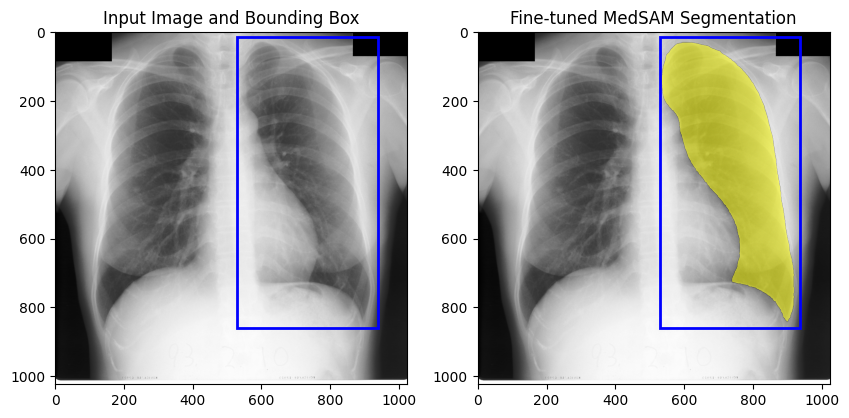

In [26]:
# prompt: do predictionfor one image and plot result

import matplotlib.pyplot as plt
import numpy as np
# Paths to folders
image_path = '/content/v2/test/original_files/JPCLN020_LL.png'
mask_path = '/content/v2/test/masks/JPCLN020_LL.png'

# Load the image
img_np = io.imread(image_path)
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

# Load the fine-tuned model
fine_tuned_model_path = '/content/medsam_finetuned.pth'

# Load the fine-tuned model
# Pass the checkpoint path to the model registry function
fine_tuned_medsam_model = sam_model_registry['vit_b'](checkpoint=fine_tuned_model_path)
fine_tuned_medsam_model = fine_tuned_medsam_model.to(DEVICE)
fine_tuned_medsam_model.eval() # Set to evaluation mode


# Get the bounding box from the mask with padding
try:
    box_np = get_bbox_from_mask(mask_path, padding=20) # Add some padding
except (FileNotFoundError, ValueError) as e:
    print(f"Error getting bounding box: {e}")
    # Handle the error, e.g., skip this image or use a default bbox
    box_np = None # Or a default box like np.array([[0, 0, W-1, H-1]])

if box_np is not None:
    # Preprocess the image for MedSAM
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(DEVICE) # Use DEVICE

    # Transfer bounding box to 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024

    # Get image embedding using the fine-tuned model
    with torch.no_grad():
        image_embedding = fine_tuned_medsam_model.image_encoder(img_1024_tensor) # Use fine_tuned_medsam_model

    # Perform inference using the fine-tuned model
    medsam_seg = medsam_inference(fine_tuned_medsam_model, image_embedding, box_1024, H, W) # Use fine_tuned_medsam_model

    # Visualize results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_3c)
    show_box(box_np[0], ax[0])
    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img_3c)
    show_mask(medsam_seg, ax[1])
    show_box(box_np[0], ax[1]) # Optionally show the bbox on the segmented image
    ax[1].set_title("Fine-tuned MedSAM Segmentation") # Update title
    plt.show()
else:
    print(f"Could not generate segmentation for {image_path} due to issues with the mask.")

